In [1]:
!pip install tqdm lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.4 MB/s eta 0:00:00a 0:00:01


In [8]:
from typing import Optional, Union, Tuple, List, Literal


class DTrOCRConfig:
    def __init__(
        self,
        gpt2_hf_model: str = 'openai-community/gpt2',
        vit_hf_model: str = 'google/vit-base-patch16-224',
        vocab_size: Optional[int] = 50257,
        max_position_embeddings: Optional[int] = 256,
        hidden_size: Optional[int] = 768,
        num_hidden_layers: Optional[int] = 8,
        num_attention_heads: Optional[int] = 12,
        patch_size: Optional[Union[Tuple[int], List[int]]] = (4, 8),      # (height, width)
        image_size: Optional[Union[Tuple[int], List[int]]] = (32, 128),   # (height, width)
        num_channels: Optional[int] = 3,
        resid_pdrop: Optional[float] = 0.1,
        embd_pdrop: Optional[float] = 0.1,
        attn_pdrop: Optional[float] = 0.1,
        layer_norm_epsilon: Optional[float] = 1e-5,
        attn_implementation: Literal['sdpa', 'flash_attention_2'] = 'sdpa'
    ):
        self.gpt2_hf_model = gpt2_hf_model
        self.vit_hf_model = vit_hf_model
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.patch_size = patch_size
        self.image_size = image_size
        self.num_channels = num_channels
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self._attn_implementation = attn_implementation

        # other GPT2 config values
        self.n_inner = None
        self.scale_attn_weights = True
        self.scale_attn_by_inverse_layer_idx = False
        self.reorder_and_upcast_attn = False
        self.add_cross_attention = False
        self.activation_function = "gelu_new"


In [9]:
import torch
import numpy as np

from dataclasses import dataclass
from typing import Optional, Union, List


@dataclass
class DTrOCRModelOutput:
    hidden_states: torch.FloatTensor
    past_key_values: torch.FloatTensor


@dataclass
class DTrOCRLMHeadModelOutput:
    logits: torch.FloatTensor
    loss: Optional[torch.FloatTensor] = None
    accuracy: Optional[torch.FloatTensor] = None
    past_key_values: Optional[torch.FloatTensor] = None


@dataclass
class DTrOCRProcessorOutput:
    pixel_values: Optional[torch.FloatTensor] = None
    input_ids: Optional[Union[torch.LongTensor, np.ndarray, List[int]]] = None
    attention_mask: Optional[Union[torch.FloatTensor, np.ndarray, List[int]]] = None
    labels: Optional[Union[torch.LongTensor, np.ndarray, List[int]]] = None


In [10]:
from transformers import GPT2Tokenizer, AutoImageProcessor

from PIL import Image
from typing import List, Union

class DTrOCRProcessor:
    def __init__(self, config: DTrOCRConfig, add_bos_token: bool = False, add_eos_token: bool = False):
        self.vit_processor = AutoImageProcessor.from_pretrained(
            config.vit_hf_model,
            size={
                "height": config.image_size[0],
                'width': config.image_size[1]
            },
            use_fast=True
        )
        self.tokeniser = GPT2Tokenizer.from_pretrained(
            config.gpt2_hf_model,
            add_bos_token=add_bos_token,
            model_max_length=config.max_position_embeddings - int(
                (config.image_size[0] / config.patch_size[0]) * (config.image_size[1] / config.patch_size[1])
            )
        )
        self.tokeniser.pad_token = self.tokeniser.bos_token
        self.tokeniser.add_eos_token = add_eos_token

        # Bind a new method to gpt2_tokeniser
        self.tokeniser.build_inputs_with_special_tokens = modified_build_inputs_with_special_tokens.__get__(
            self.tokeniser
        )

    def __call__(
        self,
        images: Union[Image.Image, List[Image.Image]] = None,
        texts: Union[str, List[str]] = None,
        return_labels: bool = False,
        input_data_format: str = 'channels_last',
        padding: Union[bool, str] = False,
        *args,
        **kwargs
    ) -> DTrOCRProcessorOutput:
        text_inputs = self.tokeniser(
            texts, padding=padding, *args, **kwargs
        ) if texts is not None else None

        image_inputs = self.vit_processor(
            images, input_data_format=input_data_format, *args, **kwargs
        ) if images is not None else None

        return DTrOCRProcessorOutput(
            pixel_values=image_inputs["pixel_values"] if images is not None else None,
            input_ids=text_inputs['input_ids'] if texts is not None else None,
            attention_mask=text_inputs['attention_mask'] if texts is not None else None,
            labels=text_inputs['input_ids'] if texts is not None and return_labels else None
        )


def modified_build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    if self.add_bos_token:
        bos_token_ids = [self.bos_token_id]
    else:
        bos_token_ids = []

    if self.add_eos_token:
        eos_token_ids = [self.eos_token_id]
    else:
        eos_token_ids = []

    output = bos_token_ids + token_ids_0 + eos_token_ids

    if token_ids_1 is None:
        return output

    return output + bos_token_ids + token_ids_1


In [11]:
import torch
from torch import nn, Tensor
from typing import Optional, Tuple, Dict, Any

import pytorch_lightning as pl

from transformers.models.vit.modeling_vit import ViTPatchEmbeddings
from transformers.generation.logits_process import LogitsProcessorList
from transformers.models.gpt2.modeling_gpt2 import GPT2Block, GPT2Model
from transformers.generation.configuration_utils import GenerationConfig
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask_for_sdpa
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer
from transformers.generation.stopping_criteria import (
    EosTokenCriteria,
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteriaList,
    StopStringCriteria,
)



class DTrOCRModel(pl.LightningModule):
    def __init__(self, config: DTrOCRConfig):
        super().__init__()
        # embeddings
        self.patch_embeddings = ViTPatchEmbeddings(config)
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        self.positional_embedding = nn.Embedding(config.max_position_embeddings, config.hidden_size)

        self.hidden_layers = nn.ModuleList([GPT2Block(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.dropout = nn.Dropout(config.attn_pdrop)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)

        self._attn_implementation = config._attn_implementation

        # initialise GPT-2 weights from Hugging Face
        self.initialise_weights(config)

    def forward(
        self,
        pixel_values: torch.Tensor,
        input_ids: torch.LongTensor,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
    ) -> DTrOCRModelOutput:
        device = input_ids.device if input_ids is not None else input_ids.device
        input_ids = input_ids.view(-1, input_ids.shape[-1])

        # past key values
        if past_key_values is None:
            past_length = 0
            past_key_values = tuple([None] * len(self.hidden_layers))
        else:
            past_length = past_key_values[0][0].size(-2)

        patch_embeddings = self.patch_embeddings(pixel_values) if past_length == 0 else None
        token_embeddings = self.token_embedding(input_ids)

        if patch_embeddings is not None:
            patch_and_token_embeddings = torch.concat([patch_embeddings, token_embeddings], dim=-2)
        else:
            patch_and_token_embeddings = token_embeddings
        input_shape = patch_and_token_embeddings.shape

        if position_ids is None or past_length == 0:
            position_ids = torch.arange(past_length, input_shape[1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0)
        else:
            position_ids = torch.ones_like(position_ids, device=position_ids.device) * past_length
        position_embeddings = self.positional_embedding(position_ids)

        hidden_states = patch_and_token_embeddings + position_embeddings
        hidden_states = self.dropout(hidden_states)

        # attention mask
        if attention_mask is not None:
            attention_mask = torch.concat(
                [
                    torch.ones(
                        attention_mask.shape[0],
                        patch_embeddings.shape[-2] if patch_embeddings is not None else past_length,
                        dtype=attention_mask.dtype,
                        device=attention_mask.device
                    ),
                    attention_mask
                ], dim=-1
            )
            if self._attn_implementation == "flash_attention_2":
                attention_mask = attention_mask if 0 in attention_mask else None
            else:
                attention_mask = _prepare_4d_causal_attention_mask_for_sdpa(
                    attention_mask=attention_mask,
                    input_shape=(input_shape[0], input_shape[-2]),
                    inputs_embeds=patch_and_token_embeddings,
                    past_key_values_length=past_length,
                )

        presents = () if use_cache else None
        for hidden_layer, layer_past in zip(self.hidden_layers, past_key_values):
            outputs = hidden_layer(
                hidden_states,
                layer_past=layer_past,
                attention_mask=attention_mask,
                use_cache=use_cache
            )
            hidden_states = outputs[0]
            if use_cache is True:
                presents = presents + (outputs[1],)

        hidden_states = self.layer_norm(hidden_states)

        return DTrOCRModelOutput(hidden_states=hidden_states, past_key_values=presents)

    def initialise_weights(self, config: DTrOCRConfig) -> None:
        # load pre-trained GPT-2
        pretrained_gpt2 = GPT2Model.from_pretrained(config.gpt2_hf_model)

        # copy hidden layer weights
        for hidden_layer, pretrained_hidden_layer in zip(self.hidden_layers, pretrained_gpt2.h):
            hidden_layer.load_state_dict(pretrained_hidden_layer.state_dict())

        # token embeddings
        self.token_embedding.load_state_dict(pretrained_gpt2.wte.state_dict())


class DTrOCRLMHeadModel(pl.LightningModule):
    def __init__(self, config: DTrOCRConfig):
        super().__init__()
        self.config = config

        self.transformer = DTrOCRModel(config)
        self.language_model_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        image_size, patch_size = config.image_size, config.patch_size

        self.image_embedding_length = int((image_size[0] / patch_size[0]) * (image_size[1] / patch_size[1]))

    def training_step(self, inputs):
        outputs = self.forward(**inputs)
        loss = outputs.loss

        self.log_dict(
            {
                "train_loss": loss,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        
        return {"loss": loss, "scores": outputs.accuracy, "y": outputs.logits}
    
    def validation_step(self, inputs):
        outputs = self.forward(**inputs)
        loss = outputs.loss
        self.log("val_loss", loss)
        return loss

    def test_step(self, inputs):
        outputs = self.forward(**inputs)
        loss = outputs.loss
        self.log("test_loss", loss)
        return {"loss": loss, "y": outputs.logits}
    
    def configure_optimizers(self):
        return torch.optim.Adam(params=self.parameters(), lr=1e-4)

    def forward(
        self,
        pixel_values: torch.Tensor,
        input_ids: torch.LongTensor,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        position_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        use_cache: Optional[bool] = False,
        labels: Optional[torch.LongTensor] = None,
    ) -> DTrOCRLMHeadModelOutput:
        transformer_output = self.transformer(
            pixel_values=pixel_values,
            input_ids=input_ids,
            past_key_values=past_key_values,
            position_ids=position_ids,
            attention_mask=attention_mask,
            use_cache=use_cache
        )
        logits = self.language_model_head(transformer_output.hidden_states)

        loss, accuracy = None, None
        if labels is not None:
            labels = labels.to(logits.device)

            # Shift so that tokens < n predict n
            shift_logits = logits[..., self.image_embedding_length:-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            loss_fct = nn.CrossEntropyLoss(reduction="none")
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            label_matches = shift_labels.view(-1) == torch.argmax(
                torch.nn.functional.softmax(shift_logits.view(-1, shift_logits.size(-1)), dim=-1), dim=-1
            )

            # reduce loss
            if attention_mask is not None:
                mask = attention_mask[..., 1:].reshape(-1)

                loss = (mask * loss).sum() / mask.sum()
                accuracy = (mask * label_matches).sum() / mask.sum()
            else:
                loss = loss.mean()
                accuracy = torch.sum(label_matches) / label_matches.shape[0]

        return DTrOCRLMHeadModelOutput(
            loss=loss,
            logits=logits,
            accuracy=accuracy,
            past_key_values=transformer_output.past_key_values
        )

    @torch.no_grad()
    def generate(
            self,
            inputs: DTrOCRProcessorOutput,
            processor: DTrOCRProcessor,
            num_beams: int = 1,
            use_cache: bool = True
    ):
        # params and configs
        batch_size = inputs.input_ids.shape[0]
        model_kwargs = {
            'pixel_values': inputs.pixel_values,
            'attention_mask': inputs.attention_mask,
            'use_cache': use_cache
        }
        generation_config = GenerationConfig(
            max_new_tokens=1,
            pad_token_id=processor.tokeniser.pad_token_id,
            eos_token_id=processor.tokeniser.eos_token_id,
            bos_token_id=processor.tokeniser.bos_token_id,
            num_beams=num_beams,
            max_length=processor.tokeniser.model_max_length
        )

        # interleave input_ids with `num_beams` additional sequences per batch
        input_ids, model_kwargs = self._expand_inputs_for_generation(
            input_ids=inputs.input_ids,
            expand_size=generation_config.num_beams,
            **model_kwargs,
        )

        # prepare stopping criteria
        prepared_stopping_criteria = self._get_stopping_criteria(
            generation_config=generation_config,
            processor=processor
        )

        if num_beams > 1:
            # prepare beam search scorer
            beam_scorer = BeamSearchScorer(
                batch_size=batch_size,
                num_beams=generation_config.num_beams,
                device=inputs.input_ids.device,
                length_penalty=generation_config.length_penalty,
                do_early_stopping=generation_config.early_stopping,
                num_beam_hyps_to_keep=generation_config.num_return_sequences,
                max_length=generation_config.max_length,
            )

            # run beam sample
            result = self._beam_search(
                input_ids,
                beam_scorer,
                logits_processor=LogitsProcessorList(),
                stopping_criteria=prepared_stopping_criteria,
                generation_config=generation_config,
                **model_kwargs,
            )

        elif num_beams == 1:
            result = self._sample(
                input_ids,
                logits_processor=LogitsProcessorList(),
                stopping_criteria=prepared_stopping_criteria,
                generation_config=generation_config,
                **model_kwargs,
            )
        else:
            raise ValueError("num_beams must be a positive integer.")

        return result

    def _sample(
        self,
        input_ids: torch.Tensor,
        logits_processor: LogitsProcessorList,
        stopping_criteria: StoppingCriteriaList,
        generation_config: GenerationConfig,
        **model_kwargs,
    ) -> torch.Tensor:
        # init values
        pad_token_id = generation_config.pad_token_id
        has_eos_stopping_criteria = any(hasattr(criteria, "eos_token_id") for criteria in stopping_criteria)

        # keep track of which sequences are already finished
        batch_size = input_ids.shape[0]
        unfinished_sequences = torch.ones(batch_size, dtype=torch.long, device=input_ids.device)
        model_kwargs = self._get_initial_cache_position(input_ids, model_kwargs)

        this_peer_finished = False
        while not this_peer_finished:
            model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)
            outputs = self(**model_inputs)

            # Clone is needed to avoid keeping a hanging ref to outputs.logits which may be very large for first
            # iteration (the clone itself is always small)
            next_token_logits = outputs.logits[:, -1, :].clone()

            # pre-process distribution
            next_token_scores = logits_processor(input_ids, next_token_logits)

            # token selection
            next_tokens = torch.argmax(next_token_scores, dim=-1)

            # finished sentences should have their next token be a padding token
            if has_eos_stopping_criteria:
                next_tokens = next_tokens * unfinished_sequences + pad_token_id * (1 - unfinished_sequences)

            # update generated ids, model inputs, and length for next step
            input_ids = torch.cat([input_ids, next_tokens[:, None]], dim=-1)

            # update generated ids, model inputs, and length for next step
            model_kwargs = self._update_model_kwargs_for_generation(outputs, model_kwargs)

            unfinished_sequences = unfinished_sequences & ~stopping_criteria(input_ids, None)
            this_peer_finished = unfinished_sequences.max() == 0

            # This is needed to properly delete outputs.logits which may be very large for first iteration
            # Otherwise a reference to outputs is kept which keeps the logits alive in the next iteration
            del outputs

        return input_ids

    def _beam_search(
        self,
        input_ids: torch.Tensor,
        beam_scorer: BeamScorer,
        logits_processor: LogitsProcessorList,
        stopping_criteria: StoppingCriteriaList,
        generation_config: GenerationConfig,
        **model_kwargs,
    ) -> torch.Tensor:
        # init values
        pad_token_id = generation_config.pad_token_id
        eos_token_id = generation_config.eos_token_id

        batch_size = len(beam_scorer._beam_hyps)
        num_beams = beam_scorer.num_beams

        batch_beam_size, cur_len = input_ids.shape
        model_kwargs = self._get_initial_cache_position(input_ids, model_kwargs)

        if num_beams * batch_size != batch_beam_size:
            raise ValueError(
                f"Batch dimension of `input_ids` should be {num_beams * batch_size}, but is {batch_beam_size}."
            )

        # initialise score of first beam with 0 and the rest with -1e9. This makes sure that only tokens
        # of the first beam are considered to avoid sampling the exact same tokens across all beams.
        beam_scores = torch.zeros((batch_size, num_beams), dtype=torch.float, device=input_ids.device)
        beam_scores[:, 1:] = -1e9
        beam_scores = beam_scores.view((batch_size * num_beams,))

        this_peer_finished = False
        decoder_prompt_len = input_ids.shape[-1]
        while not this_peer_finished:
            model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)
            outputs = self(**model_inputs)

            # Clone is needed to avoid keeping a hanging ref to outputs.logits which may be very large for first
            # iteration (the clone itself is always small)
            next_token_logits = outputs.logits[:, -1, :].clone()
            next_token_scores = nn.functional.log_softmax(
                next_token_logits, dim=-1
            )  # (batch_size * num_beams, vocab_size)

            next_token_scores_processed = logits_processor(input_ids, next_token_scores)
            next_token_scores = next_token_scores_processed + beam_scores[:, None].expand_as(
                next_token_scores_processed
            )

            # reshape for beam search
            vocab_size = next_token_scores.shape[-1]
            next_token_scores = next_token_scores.view(batch_size, num_beams * vocab_size)

            # Beam token selection: pick 1 + eos_token_id.shape[0] next tokens for each beam so we have at least 1
            # non eos token per beam.
            n_tokens_to_keep = max(2, 1 + 1) * num_beams
            next_token_scores, next_tokens = torch.topk(
                next_token_scores, n_tokens_to_keep, dim=1, largest=True, sorted=True
            )

            next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor")
            next_tokens = next_tokens % vocab_size

            # stateless
            beam_outputs = beam_scorer.process(
                input_ids,
                next_token_scores,
                next_tokens,
                next_indices,
                pad_token_id=pad_token_id,
                eos_token_id=eos_token_id,
                decoder_prompt_len=decoder_prompt_len,
            )

            beam_scores = beam_outputs["next_beam_scores"]
            beam_next_tokens = beam_outputs["next_beam_tokens"]
            beam_idx = beam_outputs["next_beam_indices"]

            input_ids = torch.cat([input_ids[beam_idx, :], beam_next_tokens.unsqueeze(-1)], dim=-1)

            model_kwargs = self._update_model_kwargs_for_generation(outputs, model_kwargs)

            # This is needed to properly delete outputs.logits which may be very large for first iteration
            # Otherwise a reference to outputs is kept which keeps the logits alive in the next iteration
            # IMPORTANT: Note that this should appear BEFORE the call to _reorder_cache() to save the maximum memory
            # (that way the memory peak does not include outputs.logits)
            del outputs

            if model_kwargs.get("past_key_values", None) is not None:
                model_kwargs["past_key_values"] = self._reorder_cache(model_kwargs["past_key_values"], beam_idx)

            # increase cur_len
            cur_len = cur_len + 1

            if beam_scorer.is_done or all(stopping_criteria(input_ids, None)):
                this_peer_finished = True

        sequence_outputs = beam_scorer.finalize(
            input_ids,
            beam_scores,
            next_tokens,
            next_indices,
            pad_token_id=pad_token_id,
            eos_token_id=eos_token_id,
            max_length=stopping_criteria.max_length,
            decoder_prompt_len=decoder_prompt_len,
        )

        return sequence_outputs["sequences"]

    def _get_stopping_criteria(
        self,
        generation_config: GenerationConfig,
        processor: Optional[DTrOCRProcessor] = None,
    ) -> StoppingCriteriaList:
        criteria = StoppingCriteriaList()
        if generation_config.max_length is not None:
            max_position_embeddings = getattr(self.config, "max_position_embeddings", None)
            criteria.append(
                MaxLengthCriteria(
                    max_length=generation_config.max_length,
                    max_position_embeddings=max_position_embeddings,
                )
            )
        if generation_config.max_time is not None:
            criteria.append(MaxTimeCriteria(max_time=generation_config.max_time))
        if generation_config.stop_strings is not None:
            if processor is None:
                raise ValueError(
                    "There are one or more stop strings, either in the arguments to `generate` or in the "
                    "model's generation config, but we could not locate a tokenizer. When generating with "
                    "stop strings, you must pass the model's tokenizer to the `tokenizer` argument of `generate`."
                )
            criteria.append(StopStringCriteria(
                stop_strings=generation_config.stop_strings, tokenizer=processor.tokeniser)
            )
        if generation_config.eos_token_id is not None:
            criteria.append(EosTokenCriteria(eos_token_id=generation_config.eos_token_id))
        return criteria

    @staticmethod
    def _reorder_cache(
            past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor
    ) -> tuple[tuple[Tensor, ...], ...]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called. This is required to match `past_key_values` with the correct
        beam_idx at every generation step.
        """
        return tuple(
            tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past)
            for layer_past in past_key_values
        )

    @staticmethod
    def _update_model_kwargs_for_generation(
        outputs: DTrOCRLMHeadModelOutput,
        model_kwargs: Dict[str, Any],
        num_new_tokens: int = 1,
    ) -> Dict[str, Any]:

        # update cache
        model_kwargs['past_key_values'] = outputs.past_key_values

        # update attention mask
        if "attention_mask" in model_kwargs:
            attention_mask = model_kwargs["attention_mask"]
            model_kwargs["attention_mask"] = torch.cat(
                [attention_mask, attention_mask.new_ones((attention_mask.shape[0], 1))], dim=-1
            )

        if (
            model_kwargs.get("use_cache", True)
            and "cache_position" in model_kwargs
            and model_kwargs["cache_position"] is not None
        ):
            model_kwargs["cache_position"] = model_kwargs["cache_position"][-1:] + num_new_tokens

        return model_kwargs

    @staticmethod
    def prepare_inputs_for_generation(
        input_ids: torch.Tensor, past_key_values=None, **kwargs
    ) -> Dict[str, Any]:
        # Omit tokens covered by past_key_values
        if past_key_values:
            past_length = past_key_values[0][0].shape[2]

            # Some generation methods already pass only the last input ID
            if input_ids.shape[1] > past_length:
                remove_prefix_length = past_length
            else:
                # Default to old behavior: keep only final ID
                remove_prefix_length = input_ids.shape[1] - 1

            input_ids = input_ids[:, remove_prefix_length:]

        attention_mask = kwargs.get("attention_mask", None)
        position_ids = kwargs.get("position_ids", None)

        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -input_ids.shape[1]:]
        else:
            position_ids = None

        model_inputs = {
            'input_ids': input_ids,
            "past_key_values": past_key_values,
            'pixel_values': kwargs['pixel_values'],
            'use_cache': kwargs.get("use_cache"),
            'labels': kwargs.get("labels"),
            'attention_mask': attention_mask,
            'position_ids': position_ids
        }

        return model_inputs

    @staticmethod
    def _get_initial_cache_position(input_ids, model_kwargs):
        if not model_kwargs.get("use_cache", True):
            model_kwargs["cache_position"] = None
            return model_kwargs

        model_kwargs["cache_position"] = torch.arange(0, input_ids.shape[-1], device=input_ids.device)
        return model_kwargs

    @staticmethod
    def _expand_inputs_for_generation(
        input_ids: Optional[torch.LongTensor],
        expand_size: int = 1,
        **model_kwargs,
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        def _expand_dict_for_generation(dict_to_expand):
            for key in dict_to_expand:
                if (
                        key != "cache_position"
                        and dict_to_expand[key] is not None
                        and isinstance(dict_to_expand[key], torch.Tensor)
                ):
                    dict_to_expand[key] = dict_to_expand[key].repeat_interleave(expand_size, dim=0)
            return dict_to_expand

        input_ids = input_ids.repeat_interleave(expand_size, dim=0)
        model_kwargs = _expand_dict_for_generation(model_kwargs)

        return input_ids, model_kwargs


In [12]:
import os
import csv

SYNTHETIC_TRAIN_DIR = '/kaggle/input/htr-synthetic/'
SYNTHETIC_TEST_DIR = '/kaggle/input/test-htr-synthetic/'

test_words = []
# train_words = []
# validation_words = []

# for idx in range(1, 8):
#     batch_csv_path = os.path.join(SYNTHETIC_TRAIN_DIR, "batch_" + str(idx) + '.csv') 
#     with open(batch_csv_path, 'r') as csv_f:
#         batch = list(csv.reader(csv_f, delimiter=","))[1:]
#         #full path for each img
#         batch_dirname = "words_" + "batch_" + str(idx)
#         if idx == 1:
#             batch_dirname = os.path.join(batch_dirname, batch_dirname)
#         batch = [[os.path.join(SYNTHETIC_TRAIN_DIR, batch_dirname, l[0]) ,l[1]] for l in batch]
#         train_words += batch
            
# for idx in range(8, 9):
#     batch_csv_path = os.path.join(SYNTHETIC_TRAIN_DIR, "batch_" + str(idx) + '.csv') 
#     with open(batch_csv_path, 'r') as csv_f:
#         batch = list(csv.reader(csv_f, delimiter=","))[1:]
#         #full path for each img
#         batch_dirname = "words_" + "batch_" + str(idx)
#         batch = [[os.path.join(SYNTHETIC_TRAIN_DIR, batch_dirname, l[0]) ,l[1]] for l in batch]
#         validation_words += batch
            
for idx in range(1, 2):
    batch_csv_path = os.path.join(SYNTHETIC_TEST_DIR, "test_" + "batch_" + str(idx) + '.csv') 
    with open(batch_csv_path, 'r') as csv_f:
        batch = list(csv.reader(csv_f, delimiter=","))[1:]
        #full path for each img
        batch = [[os.path.join(SYNTHETIC_TEST_DIR, "test_" + "words_" + "batch_" + str(idx), l[0]) ,l[1]] for l in batch]
        test_words += batch

In [13]:
test_words = np.array(test_words)
# train_words = np.array(train_words)
# validation_words = np.array(validation_words)

In [14]:
from torch.utils.data import Dataset
class IAMDataset(Dataset):
    def __init__(self, config: DTrOCRConfig, mode='train'):
        super(IAMDataset, self).__init__()
        if mode == "train":
            self.words = train_words
        if mode == "test":
            self.words = test_words
        if mode == "validation":
            self.words = validation_words

        self.processor = DTrOCRProcessor(config, add_eos_token=True, add_bos_token=True)
        
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, item):
        inputs = self.processor(
            images=Image.open(self.words[item][0]).convert('RGB'),
            texts=self.words[item][1],
            padding='max_length',
            return_labels=True,
            return_tensors='pt',

        )
        return {
            'pixel_values': inputs.pixel_values[0],
            'input_ids': inputs.input_ids[0],
            'attention_mask': inputs.attention_mask[0],
            'labels': inputs.labels[0]
        }

config = DTrOCRConfig()


In [15]:
from torch.utils.data import DataLoader
import multiprocessing as mp

class DTrOCRDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "path/to/dir", batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_data = IAMDataset(mode='train', config=config)
        self.test_data = IAMDataset(mode='test', config=config)
        self.validation_data = IAMDataset(mode='validation', config=config)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True, num_workers=mp.cpu_count(), drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(self.validation_data, batch_size=32, shuffle=False, num_workers=mp.cpu_count(), drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=32, shuffle=False, num_workers=mp.cpu_count(), drop_last=True)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


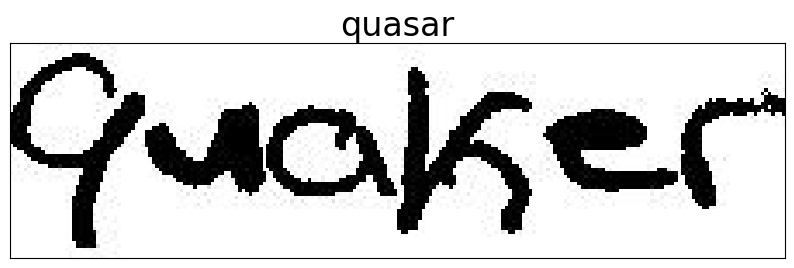

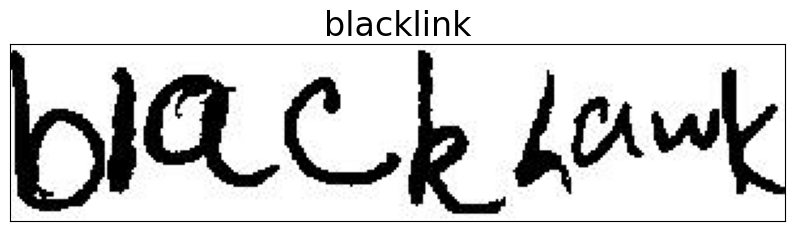

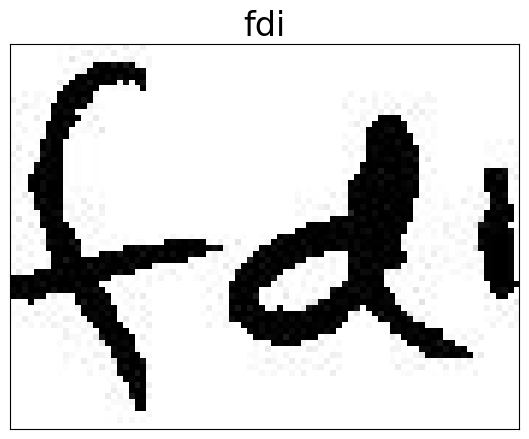

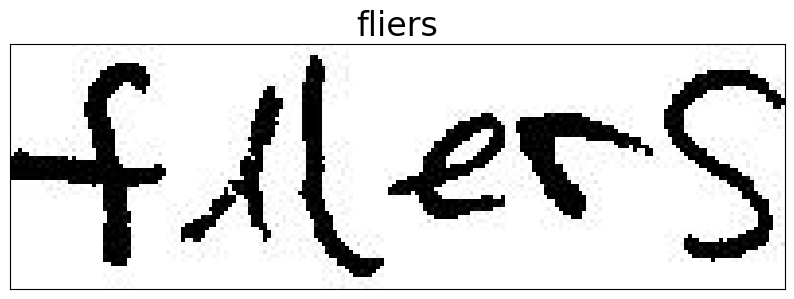

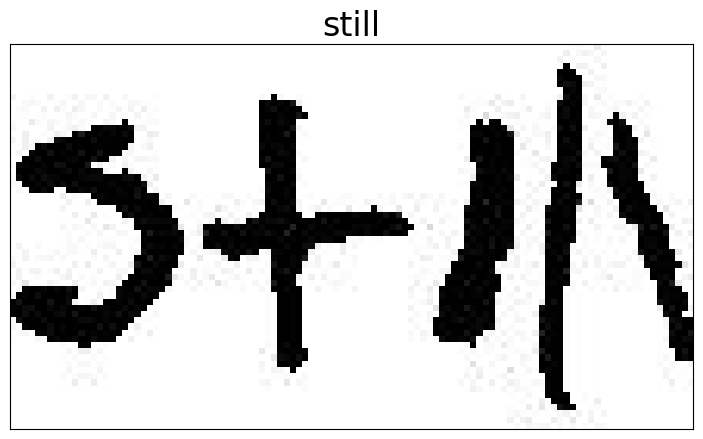

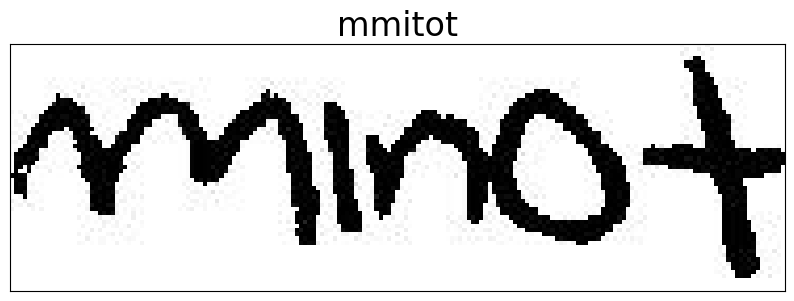

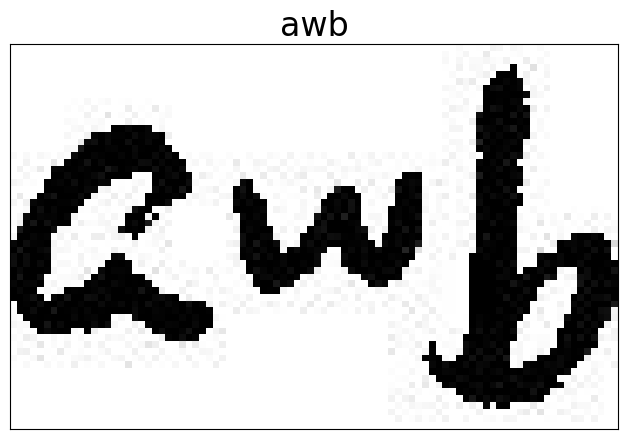

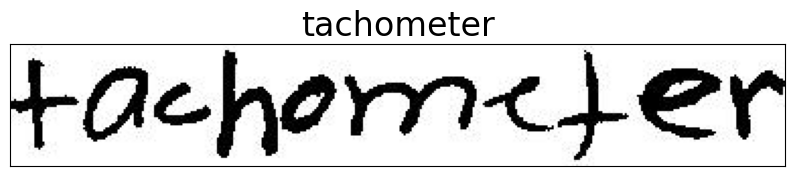

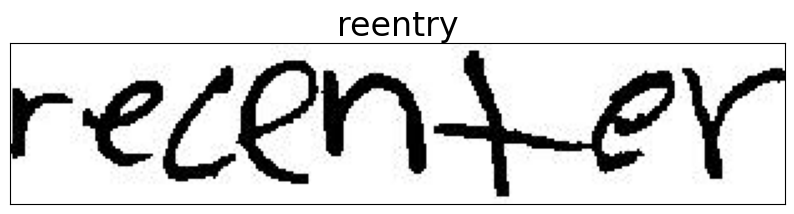

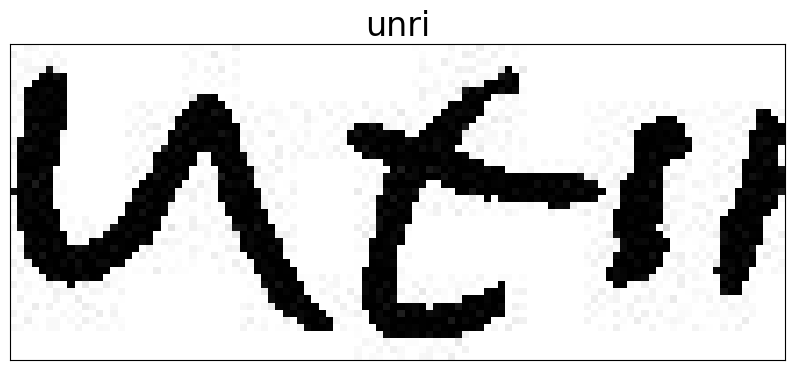

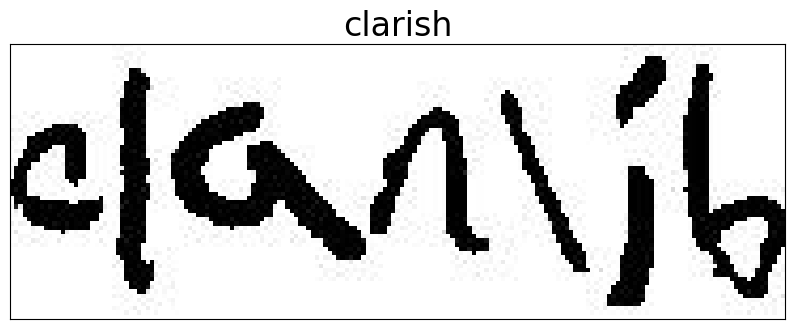

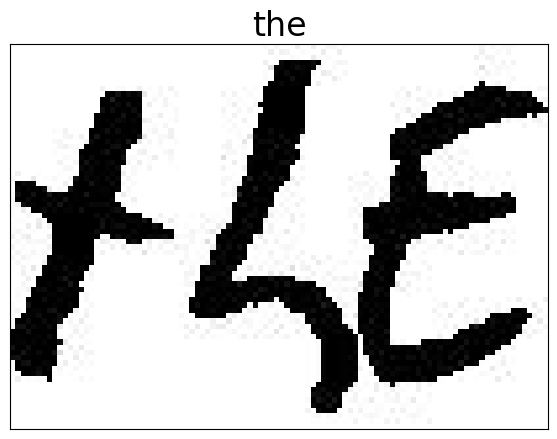

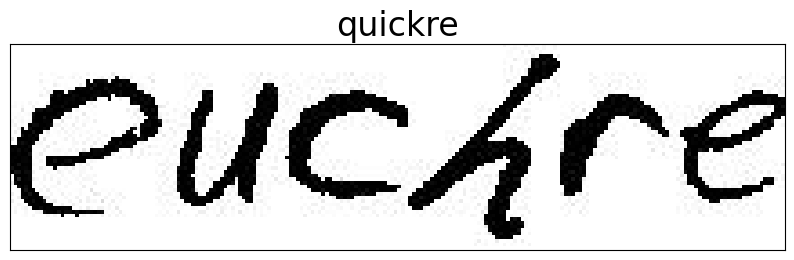

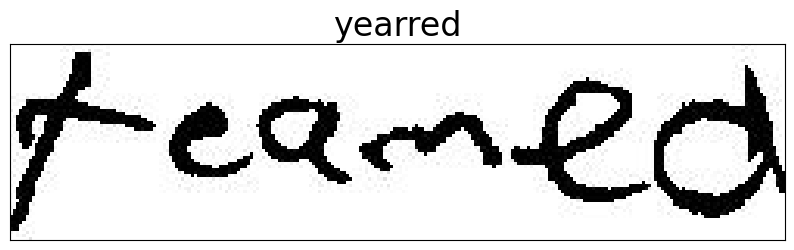

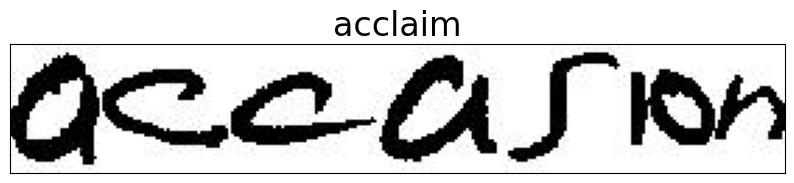

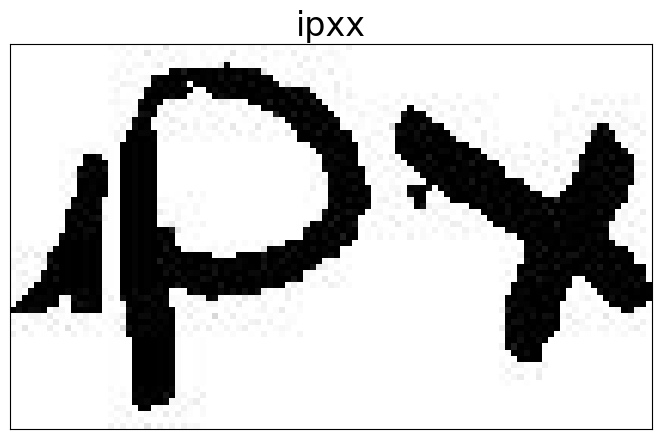

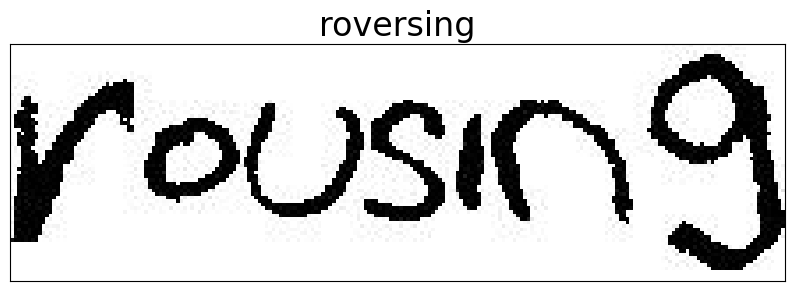

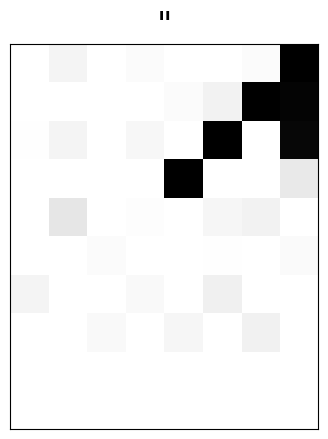

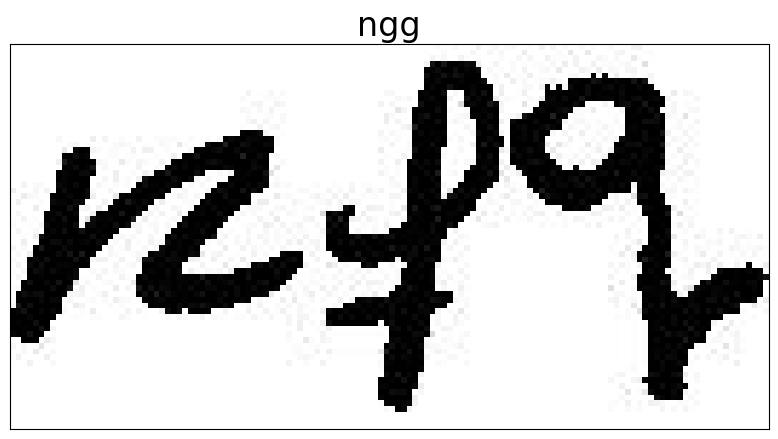

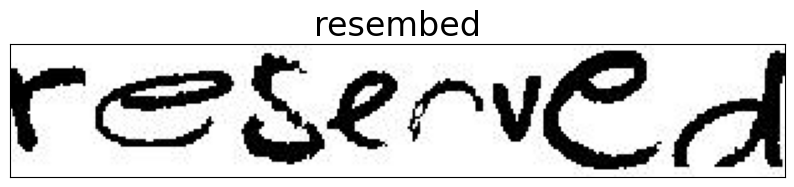

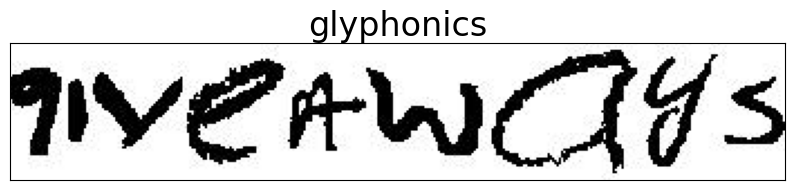

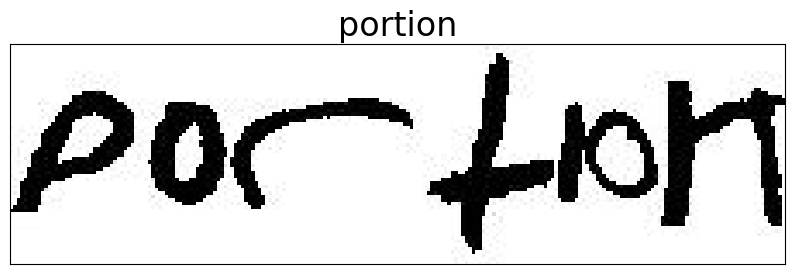

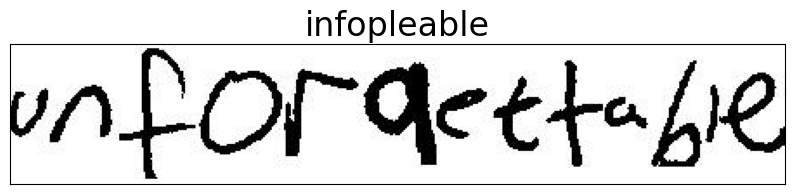

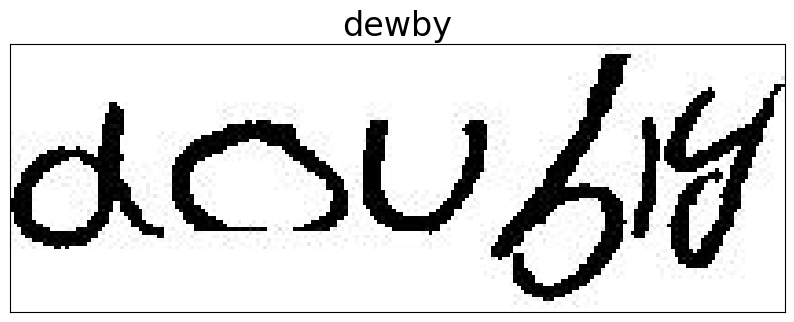

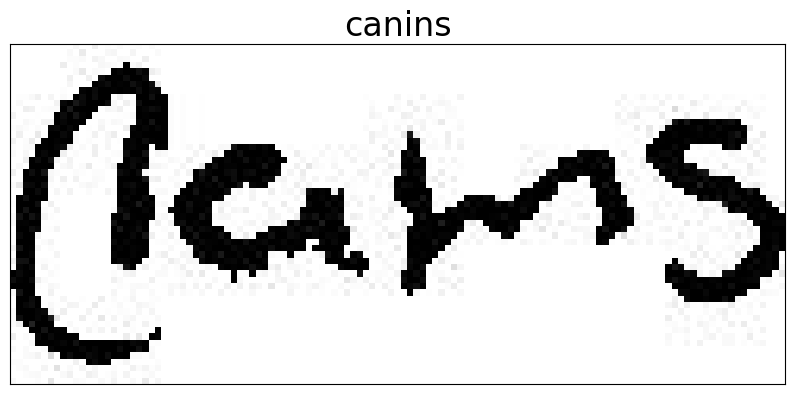

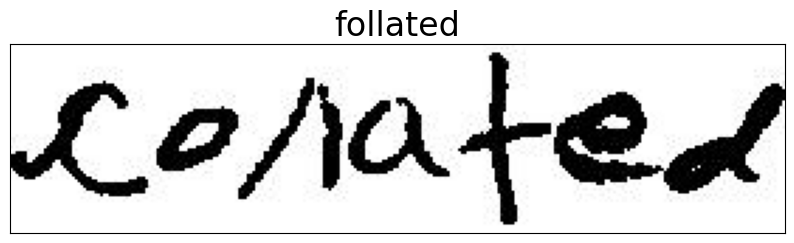

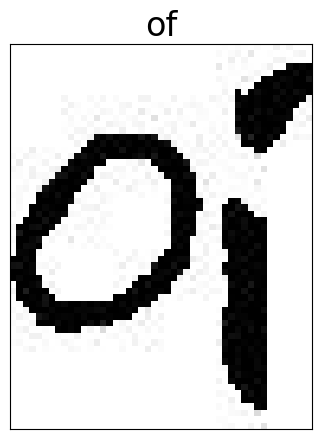

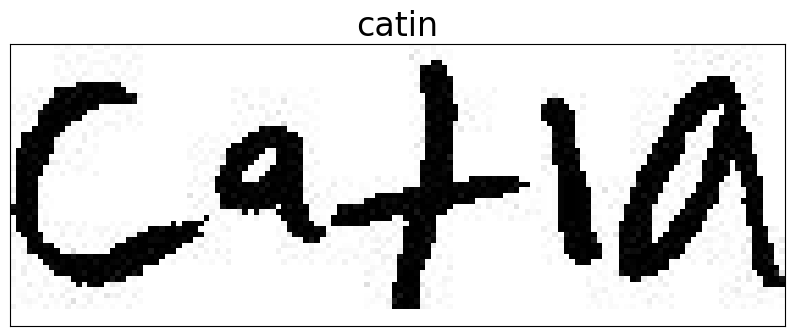

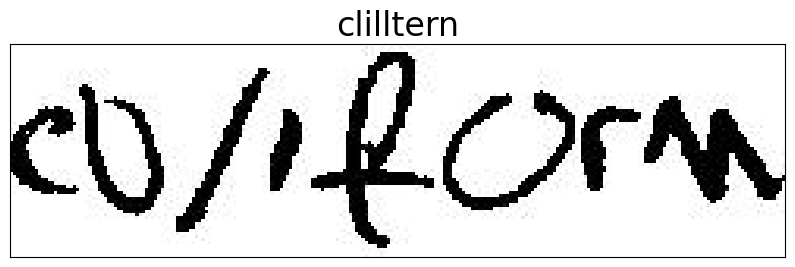

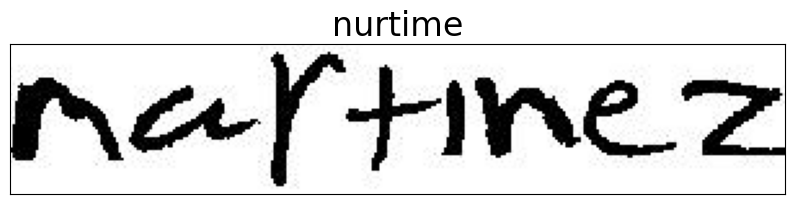

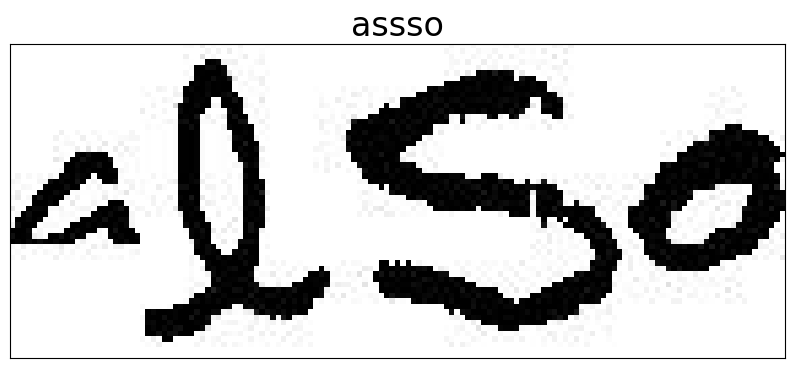

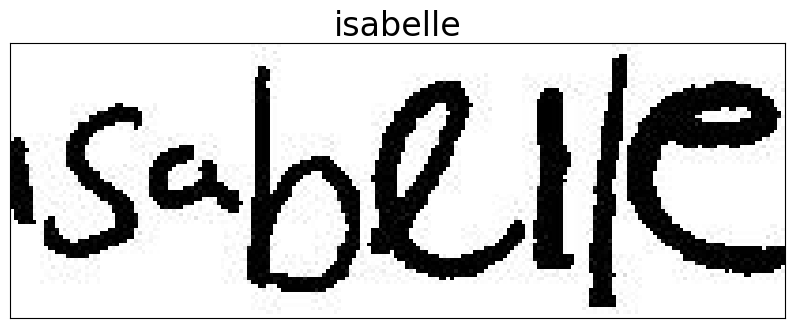

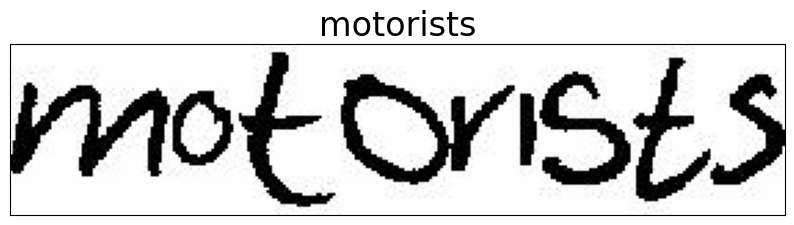

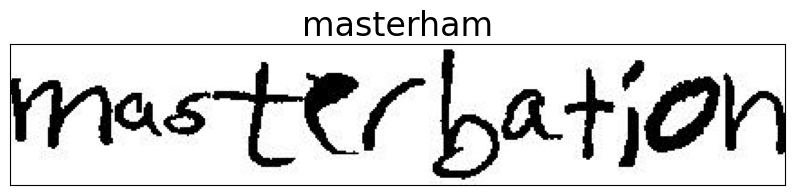

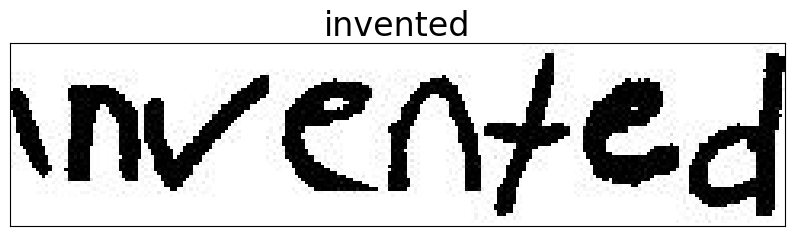

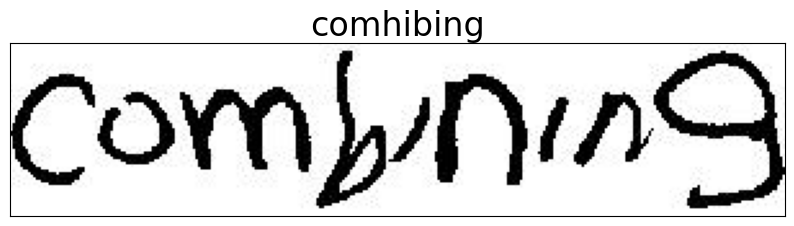

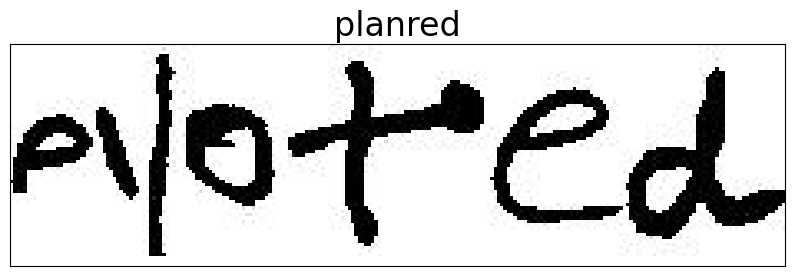

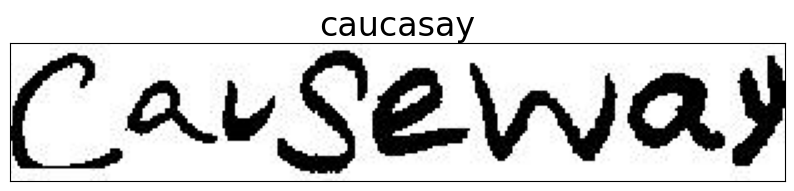

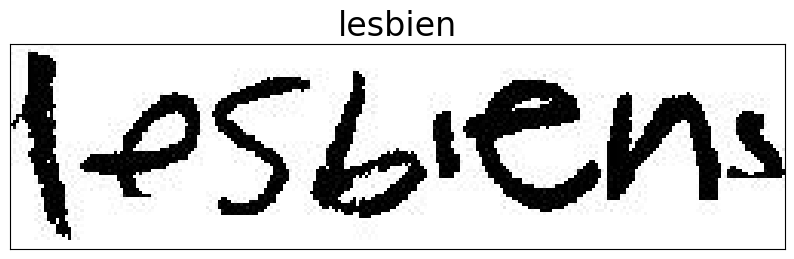

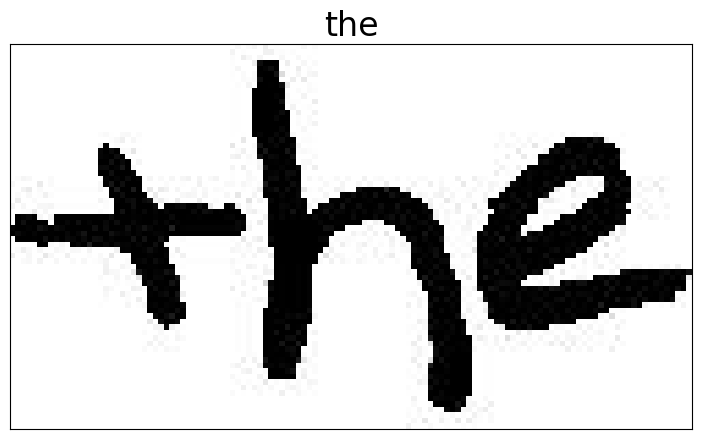

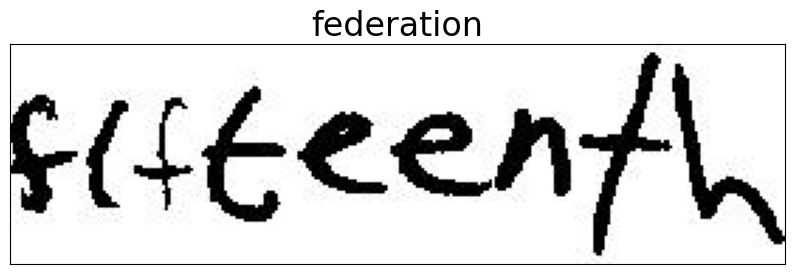

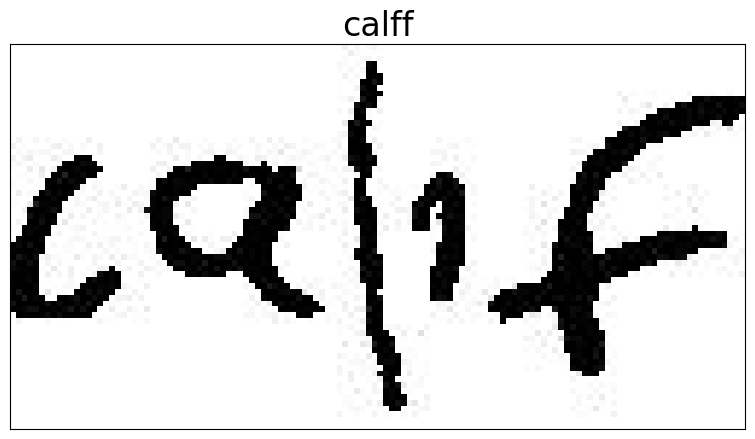

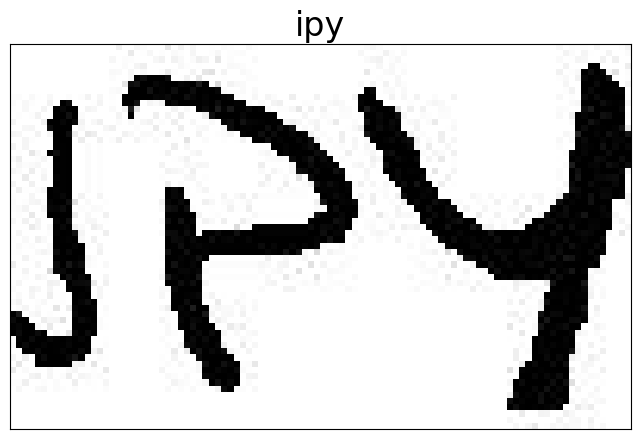

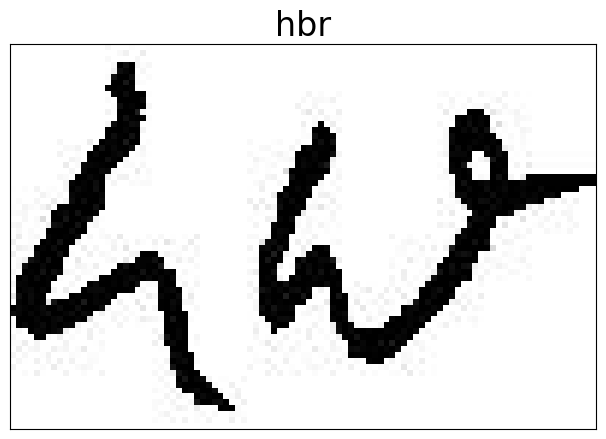

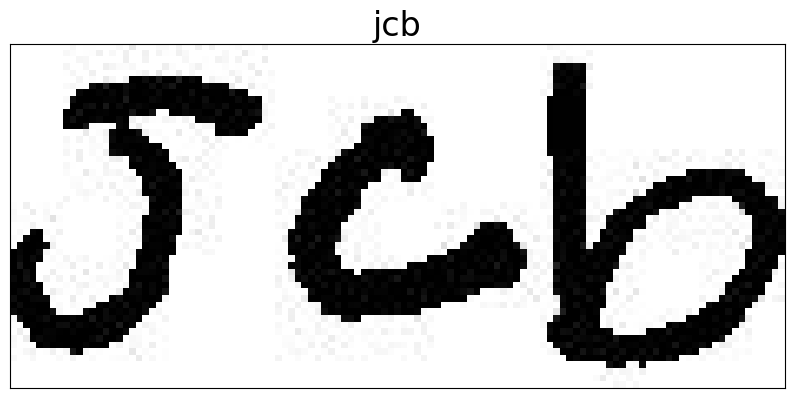

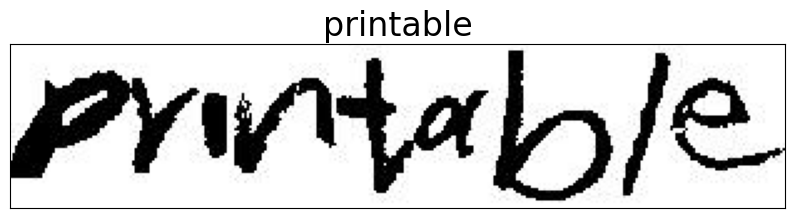

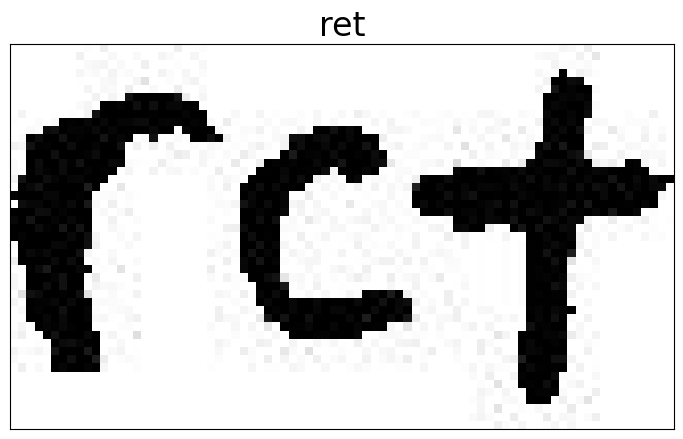

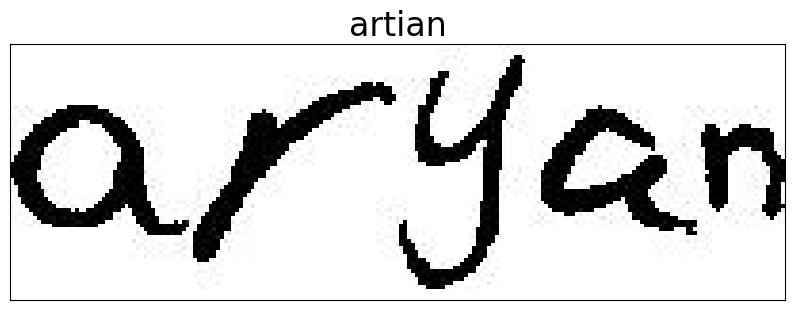

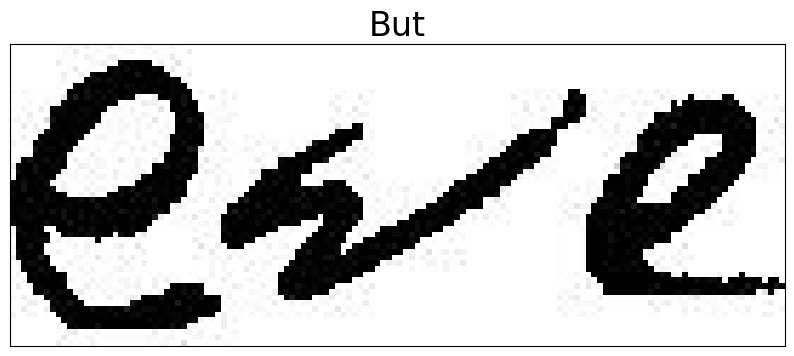

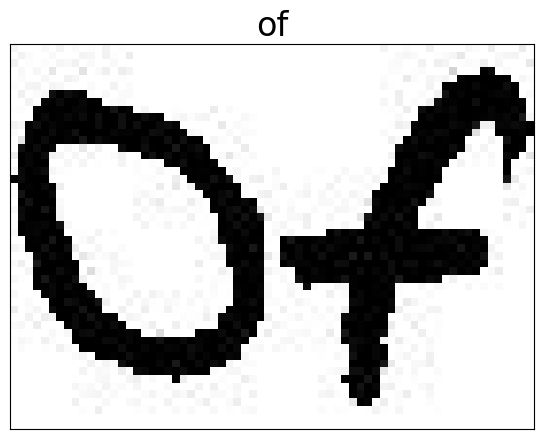

In [28]:
import matplotlib.pyplot as plt

checkpoint_path = "/kaggle/input/notebookfc03b07dda/lightning_logs/version_0/checkpoints/epoch=2-step=12958.ckpt"
model = DTrOCRLMHeadModel.load_from_checkpoint(checkpoint_path, config=config)
model.to("cuda:0")
test_processor = DTrOCRProcessor(config)

for image_file, txt in test_words[:50]:

    image = Image.open(image_file).convert('RGB')
    inputs = test_processor(
        images=image, 
        texts=test_processor.tokeniser.bos_token,
        return_tensors='pt'
    )
    
    inputs = DTrOCRProcessorOutput(
        pixel_values=inputs.pixel_values.to(model.device),
        input_ids=inputs.input_ids.to(model.device),
        attention_mask=inputs.attention_mask.to(model.device),
        labels=inputs.labels
    )
    
    model_output = model.generate(
        inputs, 
        test_processor, 
        num_beams=3
    )
    
    predicted_text = test_processor.tokeniser.decode(model_output[0], skip_special_tokens=True)
    
    plt.figure(figsize=(10, 5))
    plt.title(predicted_text, fontsize=24)
    plt.imshow(np.array(image, dtype=np.uint8))
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
# torch.set_float32_matmul_precision("medium")

# from lightning.pytorch.profilers import SimpleProfiler
# from pytorch_lightning.callbacks import EarlyStopping, Callback

# class MyPrintingCallback(Callback):
#     def __init__(self):
#         super().__init__()

#     def on_train_start(self, trainer, pl_module):
#         print("Starting to train!")

#     def on_train_end(self, trainer, pl_module):
#         print("Training is done.")

# dm = DTrOCRDataModule()

# NUM_EPOCHS = 10
# ACCELERATOR = "gpu"
# DEVICES = [0, 1]
# PRECISION = "bf16-mixed"

# model = DTrOCRLMHeadModel(config)

# trainer = pl.Trainer(
#     strategy='ddp_notebook',
#     accelerator=ACCELERATOR,
#     devices=DEVICES,
#     min_epochs=1,
#     max_epochs=NUM_EPOCHS,
#     precision=PRECISION,
#     callbacks=[MyPrintingCallback(), EarlyStopping(monitor="val_loss")],
#     default_root_dir="/kaggle/working/",
#     max_time="00:09:00:00",
#     profiler=SimpleProfiler(),
# )

# trainer.fit(model, dm)
# trainer.validate(model, dm)
# trainer.test(model, dm)